<a href="https://colab.research.google.com/github/AedinMcCann/Applied-Economics/blob/main/FINAL_MSFT_LSTM_SENTIMENT_60M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3MB 3.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=9f9e79600a30f01ef4e4a7f97542ff6478d9dd07f4d904a915363522029a3cc5
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=4403d81f81c81667658a78459515c829340bf3096c1018f8e6273119aaa4b166
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


In [ ]:
# Import necessary packages
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns 

import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
# Get stock data
start='2020-01-01'
end='2021-01-02'
df = yf.download(tickers = "MSFT",start=start,end=end,interval = "60m")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.tail()


[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume,Next_close
1759,2020-12-31 11:30:00-05:00,220.274994,220.460007,219.679993,219.910004,219.910004,2132707,220.285004
1760,2020-12-31 12:30:00-05:00,219.914993,220.406494,219.800003,220.285004,220.285004,1172462,220.559998
1761,2020-12-31 13:30:00-05:00,220.286896,220.600006,219.880005,220.559998,220.559998,1402907,221.369995
1762,2020-12-31 14:30:00-05:00,220.559998,221.630005,220.529999,221.369995,221.369995,1800116,222.449997
1763,2020-12-31 15:30:00-05:00,221.369995,223.000000,221.160095,222.449997,222.449997,3623446,NaN


Text(0, 0.5, 'Cost (USD)')

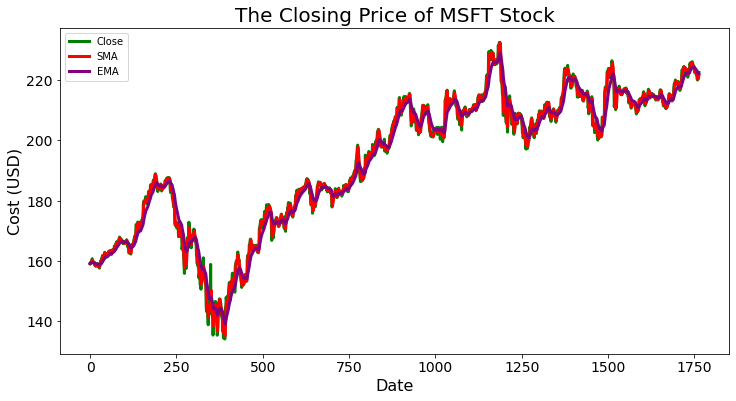

In [ ]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

# Colors for the line plot
colors = ['green', 'red', 'purple']
df_plt = df[['Close', 'SMA', 'EMA']]

# line plot
df_plt.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# title and labels
plt.title('The Closing Price of MSFT Stock', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cost (USD)', fontsize=16)

In [ ]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Datetime')
df.head()

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv
Datetime,,,,,,,,,,
2020-01-02 09:30:00-05:00,158.779999,159.554993,158.330002,159.100006,159.100006,5598544,159.485001,159.100006,159.100006,0.0
2020-01-02 10:30:00-05:00,159.095001,159.630005,158.990005,159.485001,159.485001,2349407,159.529999,159.292503,159.138506,2349407.0
2020-01-02 11:30:00-05:00,159.479996,159.619995,159.110001,159.529999,159.529999,1784440,159.615005,159.371668,159.177655,4133847.0
2020-01-02 12:30:00-05:00,159.520004,159.800003,159.445007,159.615005,159.615005,1571495,159.934998,159.543335,159.221390,5705342.0
2020-01-02 13:30:00-05:00,159.615005,159.949997,159.529999,159.934998,159.934998,1508504,160.070007,159.693334,159.292751,7213846.0


In [ ]:
df = df.reset_index()
df['date'] = df['Datetime'].dt.date  # for daily sentiment
df['datehour'] = df['Datetime'].dt.hour     #For hourly sentiment
df['hour_id'] = df[df.columns[-2:]].apply(
    lambda x: '.'.join(x.dropna().astype(str)),
    axis=1
)
df

,Datetime,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv,date,datehour,hour_id
0,2020-01-02 09:30:00-05:00,158.779999,159.554993,158.330002,159.100006,159.100006,5598544,159.485001,159.100006,159.100006,0.0,2020-01-02,9,2020-01-02.9
1,2020-01-02 10:30:00-05:00,159.095001,159.630005,158.990005,159.485001,159.485001,2349407,159.529999,159.292503,159.138506,2349407.0,2020-01-02,10,2020-01-02.10
2,2020-01-02 11:30:00-05:00,159.479996,159.619995,159.110001,159.529999,159.529999,1784440,159.615005,159.371668,159.177655,4133847.0,2020-01-02,11,2020-01-02.11
3,2020-01-02 12:30:00-05:00,159.520004,159.800003,159.445007,159.615005,159.615005,1571495,159.934998,159.543335,159.221390,5705342.0,2020-01-02,12,2020-01-02.12
4,2020-01-02 13:30:00-05:00,159.615005,159.949997,159.529999,159.934998,159.934998,1508504,160.070007,159.693334,159.292751,7213846.0,2020-01-02,13,2020-01-02.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,2020-12-31 11:30:00-05:00,220.274994,220.460007,219.679993,219.910004,219.910004,2132707,220.285004,220.563334,222.495879,357081786.0,2020-12-31,11,2020-12-31.11
1760,2020-12-31 12:30:00-05:00,219.914993,220.406494,219.800003,220.285004,220.285004,1172462,220.559998,220.158335,222.274791,358254248.0,2020-12-31,12,2020-12-31.12
1761,2020-12-31 13:30:00-05:00,220.286896,220.600006,219.880005,220.559998,220.559998,1402907,221.369995,220.251668,222.103312,359657155.0,2020-12-31,13,2020-12-31.13
1762,2020-12-31 14:30:00-05:00,220.559998,221.630005,220.529999,221.369995,221.369995,1800116,222.449997,220.738332,222.029980,361457271.0,2020-12-31,14,2020-12-31.14


In [ ]:
sent = pd.read_csv('MSFT_sentiment_hr.csv')
sent

,Unnamed: 0,hour_id,compound,Count,average
0,0,2019-12-31.23,-0.4019,2,-0.200950
1,1,2020-01-01.16,-0.1661,1,-0.166100
2,2,2020-01-01.21,-0.0697,2,-0.034850
3,3,2020-01-01.22,0.2586,1,0.258600
4,4,2020-01-01.23,0.3818,1,0.381800
...,...,...,...,...,...
7559,7559,2020-12-31.4,1.3475,3,0.449167
7560,7560,2020-12-31.5,0.8979,4,0.224475
7561,7561,2020-12-31.7,-0.2924,1,-0.292400
7562,7562,2020-12-31.8,0.0000,2,0.000000


In [ ]:
# Import sentiment data
#df = df.reset_index()
#df['Date'] = pd.to_datetime(df['Date'])
#sent = pd.read_csv('MSFT_sentiment_hr.csv')
#sent = sent.rename(columns={'date':'Date'})
#sent['Date'] = pd.to_datetime(sent['Date'])

df = pd.merge(df, sent, on = 'hour_id')
df

,Datetime,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv,date,datehour,hour_id,Unnamed: 0,compound,Count,average
0,2020-01-02 10:30:00-05:00,159.095001,159.630005,158.990005,159.485001,159.485001,2349407,159.529999,159.292503,159.138506,2349407.0,2020-01-02,10,2020-01-02.10,8,0.5106,2,0.255300
1,2020-01-02 11:30:00-05:00,159.479996,159.619995,159.110001,159.529999,159.529999,1784440,159.615005,159.371668,159.177655,4133847.0,2020-01-02,11,2020-01-02.11,9,0.0000,1,0.000000
2,2020-01-02 12:30:00-05:00,159.520004,159.800003,159.445007,159.615005,159.615005,1571495,159.934998,159.543335,159.221390,5705342.0,2020-01-02,12,2020-01-02.12,10,0.5267,1,0.526700
3,2020-01-02 13:30:00-05:00,159.615005,159.949997,159.529999,159.934998,159.934998,1508504,160.070007,159.693334,159.292751,7213846.0,2020-01-02,13,2020-01-02.13,11,1.6208,2,0.810400
4,2020-01-02 14:30:00-05:00,159.919998,160.100006,159.850006,160.070007,160.070007,2836577,160.729996,159.873337,159.370476,10050423.0,2020-01-02,14,2020-01-02.14,12,-0.0712,6,-0.011867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,2020-12-31 10:30:00-05:00,221.505005,221.615005,220.229996,220.279999,220.279999,1941240,219.910004,221.149999,222.783198,359214493.0,2020-12-31,10,2020-12-31.10,7545,0.6637,1,0.663700
1545,2020-12-31 11:30:00-05:00,220.274994,220.460007,219.679993,219.910004,219.910004,2132707,220.285004,220.563334,222.495879,357081786.0,2020-12-31,11,2020-12-31.11,7546,0.0000,1,0.000000
1546,2020-12-31 13:30:00-05:00,220.286896,220.600006,219.880005,220.559998,220.559998,1402907,221.369995,220.251668,222.103312,359657155.0,2020-12-31,13,2020-12-31.13,7547,0.7579,1,0.757900
1547,2020-12-31 14:30:00-05:00,220.559998,221.630005,220.529999,221.369995,221.369995,1800116,222.449997,220.738332,222.029980,361457271.0,2020-12-31,14,2020-12-31.14,7548,0.0000,2,0.000000


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv,datehour,Unnamed: 0,compound,Count,average
count,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1.549000e+03,1548.000000,1549.000000,1549.000000,1.549000e+03,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000
mean,192.529011,193.430876,191.587759,192.533375,192.533375,4.611804e+06,192.547270,192.522803,192.293548,2.304180e+08,12.198838,3787.248547,0.312523,15.728857,0.041792
std,22.859709,22.650990,23.017500,22.839250,22.839250,3.213947e+06,22.832893,22.791917,22.599242,1.344037e+08,1.970840,2172.138666,1.982829,29.219588,0.225441
min,134.160004,137.250000,132.520004,134.139999,134.139999,0.000000e+00,134.139999,135.313334,139.093149,-7.974553e+07,9.000000,8.000000,-17.594100,1.000000,-0.845500
25%,174.050003,174.639999,173.300003,174.009995,174.009995,2.592887e+06,174.024998,174.038335,173.391485,1.173628e+08,11.000000,1910.000000,-0.460600,3.000000,-0.055300
50%,199.039993,200.000000,197.809998,199.190002,199.190002,3.558186e+06,199.501701,199.059998,199.037288,2.773586e+08,12.000000,3773.000000,0.212600,7.000000,0.023575
75%,211.990005,212.860001,211.214005,212.042496,212.042496,5.542564e+06,212.027195,211.936330,211.749000,3.429836e+08,14.000000,5671.000000,0.952700,15.000000,0.140094
max,232.354996,232.860001,231.350006,232.350006,232.350006,2.795370e+07,232.350006,232.180003,228.858003,4.074811e+08,15.000000,7563.000000,22.077400,337.000000,0.955900


In [ ]:
df.skew()

Open         -0.478175
High         -0.444976
Low          -0.505537
Close        -0.479158
Adj Close    -0.479158
Volume        2.402115
Next_close   -0.481485
SMA          -0.473824
EMA          -0.459114
obv          -0.653970
datehour     -0.131549
Unnamed: 0   -0.014250
compound      1.153868
Count         5.610992
average       0.286361
dtype: float64

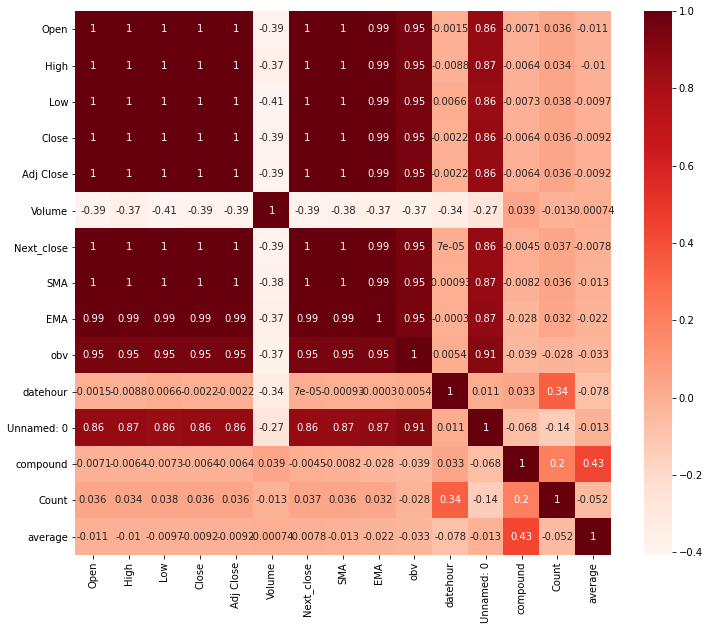

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor["Next_close"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Open          0.996011
High          0.996448
Low           0.996731
Close         0.997246
Adj Close     0.997246
Next_close    1.000000
SMA           0.996337
EMA           0.989088
obv           0.953303
Unnamed: 0    0.863408
Name: Next_close, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7250b15d10>,
      dtype=object)

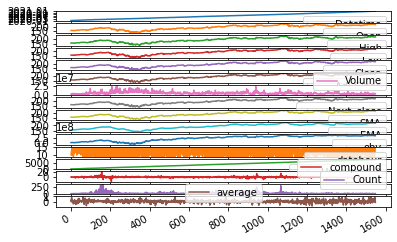

In [ ]:
df.plot(subplots=True)


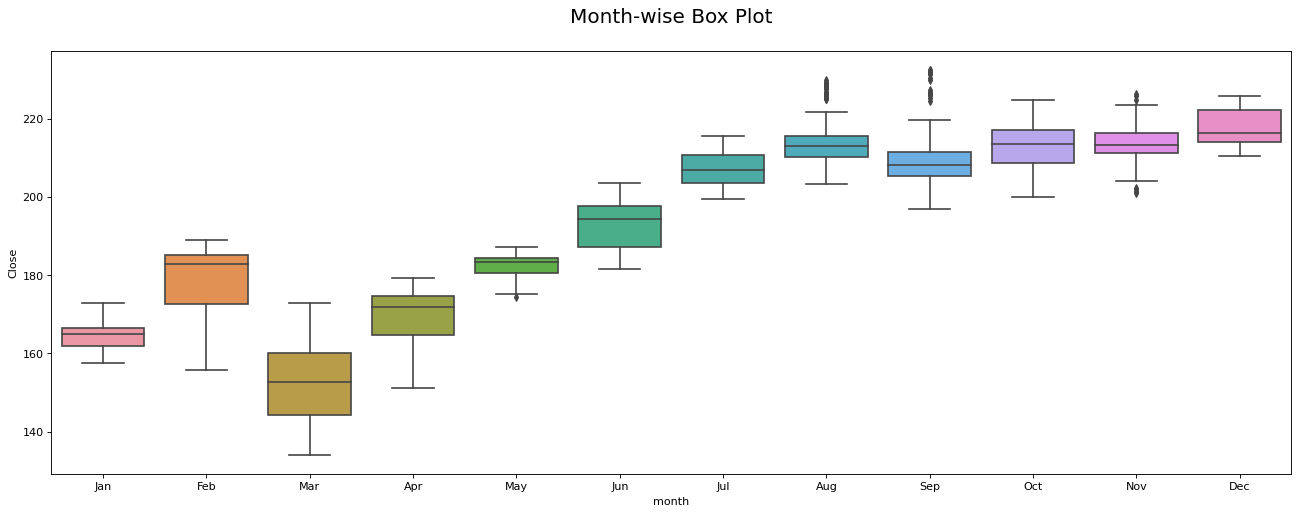

In [ ]:
# Boxplot of month-wise distribution
df.reset_index(inplace=True)
# Prepare data
df['month'] = [d.strftime('%b') for d in df.Datetime]
# Draw Plot
fig, axes = plt.subplots(1, 1, figsize=(20,7), dpi= 80)
sns.boxplot(x='month', y='Close', data=df)
# Set Title
axes.set_title('Month-wise Box Plot\n', fontsize=18)
plt.show()

# This boxplot shows a clear difference between prices at the start of the year and the end. The distribution is high in August, Sept, Nov and Dec. 

In [ ]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

In [ ]:
# Scale data with MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()

# Data Loader Parameters
BATCH_SIZE = 17       # Factors of 1411 (train size):  1, 17, 83, 1411
BUFFER_SIZE = 100
TRAIN_SPLIT = round(len(df)*0.8)  # 80-20 train-test split 
print(TRAIN_SPLIT) # Batches should be factor of train size

# LSTM Parameters
EVALUATION_INTERVAL = 20   
EPOCHS = 500 # Early stopping implemented, so this can be artbitrarily high and still work
PATIENCE = 10  # number of epochs to wait before early stop if no progress on the validation set. # Tested this out with other values 3 and 5

1239


**Scaling the Data**

The values in our datset are of different scales which can increase the difficulty of the problem being modeled. The volume of traders per day is much higher than the value for the previous day's high, open, etc. This high value mayresult in a model that learns large weight values. A model with large weight values is often unstable, meaning that it may suffer from poor performance during learning and sensitivity to input values resulting in higher generalization error. For this reason we scale our data before proceeding

MinMaxScaler() subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. This scaling method preserves the shape of the original distribution. It doesn't meaningfully change the information embedded in the original data. Note that MinMaxScaler doesn't reduce the importance of outliers. The default range for the feature returned by MinMaxScaler is 0 to 1

Note on activation function:
Ensure that the scale of your output variable matches the scale of the activation function (transfer function) on the output layer of your network.
If your output activation function has a range of [0,1], then you must ensure that the target values lie within that range. But it is generally better to choose an output activation function suited to the distribution of the targets than to force your data to conform to the output activation function.


In [ ]:
# Scaled data with MinMaxScaler
data = df.values
# define min max scaler
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(data)


**Linear Regression**

In order to get a measure for which to compare the LSTM model, I will create a control value for MSE using local linear regression. Note that this is a naive regression which is biased. 



In [ ]:
pip install statsmodels

In [ ]:
import numpy as np
def mean_absolute_percentage_error(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [ ]:
# Split data
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X = dataset[:-1,1:]
y = dataset[:-1, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Train algorithm
regressor = LinearRegression()  
regressor = regressor.fit(X_train, y_train) 

#To retrieve the intercept:
print('Intercept:', regressor.intercept_)
#For retrieving the slope:
print('Coefficients:', regressor.coef_)

# Predicted value
y_pred = regressor.predict(X_test)

df_lin = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
df_lin

Intercept: -0.0028070694104127547
Coefficients: [ 0.6717795   0.01029128 -0.0170859   0.00716106  0.33352247 -0.02873204
  0.0202962   0.01062816  0.00333647]
Mean Absolute Error: 0.01182495532981691
Mean Absolute Percentage Error: 5.26889706310436
Mean Squared Error: 0.00038608918852095974
Root Mean Squared Error: 0.019649152361385966


,Actual,Predicted
0,0.329244,0.329044
1,0.665818,0.672522
2,0.812646,0.834272
3,0.321963,0.329586
4,0.541085,0.543482
...,...,...
305,0.770492,0.768942
306,0.768964,0.768118
307,0.782303,0.803602
308,0.701354,0.697737


In [ ]:
display(pd.DataFrame(dataset, columns = df.columns, index= df.index).tail())

,Next_close,Close,Volume,Open,High,Low,SMA,EMA,obv,average
1544,0.873333,0.877100,0.069445,0.889506,0.882387,0.887483,0.886132,0.932325,0.900936,0.837793
1545,0.877151,0.873333,0.076294,0.876979,0.870307,0.881918,0.880076,0.929125,0.896559,0.469357
1546,0.888199,0.879951,0.050187,0.877101,0.871771,0.883942,0.876858,0.924751,0.901844,0.890085
1547,0.899196,0.888199,0.064396,0.879882,0.882544,0.890519,0.881882,0.923934,0.905539,0.469357
1548,NaN,0.899196,0.129623,0.888131,0.896873,0.896895,0.889332,0.924402,0.912976,0.389253


In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

Training Dataset: The sample of data used to fit the model.

Validation Dataset: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.

Test Dataset: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In [ ]:
past_history = 320    # Decide on a past_history and give reasoning
future_target = 1
STEP = 1    

x_train_single, y_train_single = multivariate_data(dataset[:,1:], dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset[:,1:], dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)


In [ ]:
print(x_train_single.shape)
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(x_train_single.shape[-2:])

(919, 320, 9)
Single window of past history : (320, 9)
(320, 9)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() # Should this shuffle? Timeseries? Or with a sufficient buffer is it advised?
#train_data_single = train_data_single.cache().batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()  ## Should this shuffle? Timeseries? Or with a sufficient buffer is it advised?
#val_data_single = train_data_single.cache().batch(BATCH_SIZE).repeat()
#train_data_single.shape

Choosing the correct optimizer: 

RMSprop:
* Maintain a moving (discounted) average of the square of gradients
* Divide the gradient by the root of this average
adam: Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

SGD: Gradient descent (with momentum) optimizer.

Choice of Loss:
MAPE?
Can't use with scaled data

Mean absolute scaled error (MASE): 

a measure of the accuracy of forecasts. It is the mean absolute error of the forecast values, divided by the mean absolute error of the in-sample one-step naive forecast. 

Mean Squared Log Error:



In [ ]:
from keras import regularizers
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                           input_shape=x_train_single.shape[-2:]))    # LSTM layer with input shape of x_train_single.shape[-2:]
single_step_model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
single_step_model.add(tf.keras.layers.Dense(1)) # activation = sigmoid? Because I have normalised it to be between -1 and 1? Or no activation?

single_step_model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #adam said to be best in CV


In [ ]:
# Grid Search

def build_classifier(optimizer):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                 kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                 input_shape=x_train_single.shape[-2:]))    # LSTM layer with input shape of x_train_single.shape[-2:]
  model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
  model.add(tf.keras.layers.Dense(1)) # activation = sigmoid? Because I have normalised it to be between -1 and 1? Or no activation?
  model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #
  return model

grid_model = KerasClassifier(build_fn=build_classifier)
parameters = {'batch_size' : [1, 17, 83, 1411],
              'optimizer' : ['adam','RMSprop'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            scoring = 'neg_mean_squared_error',
                            cv = 2)

In [ ]:
#GridSearchCV?
grid_search = grid_search.fit(x_train_single, y_train_single)

459/459 [==============================] - 26s 52ms/step - loss: 59291.1953 - mean_absolute_error: 210.8893 - mape: 8266132.5000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


460/460 [==============================] - 26s 52ms/step - loss: 67022.5078 - mean_absolute_error: 224.0438 - mape: 3083870.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


459/459 [==============================] - 25s 52ms/step - loss: 59915.5039 - mean_absolute_error: 212.3934 - mape: 6347779.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


460/460 [==============================] - 26s 52ms/step - loss: 66983.7656 - mean_absolute_error: 223.9159 - mape: 101654.3984


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


27/27 [==============================] - 3s 59ms/step - loss: 60437.5898 - mean_absolute_error: 213.5830 - mape: 697098.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 5s 97ms/step - loss: 68141.7031 - mean_absolute_error: 226.4539 - mape: 157833.3906


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


27/27 [==============================] - 3s 58ms/step - loss: 60382.1406 - mean_absolute_error: 213.4529 - mape: 1800043.6250


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 5s 96ms/step - loss: 67854.3906 - mean_absolute_error: 225.9157 - mape: 49483.7148


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


6/6 [==============================] - 3s 100ms/step - loss: 60528.9062 - mean_absolute_error: 213.7939 - mape: 544805.6875


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


6/6 [==============================] - 3s 104ms/step - loss: 67753.0703 - mean_absolute_error: 225.6819 - mape: 1070170.7500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


6/6 [==============================] - 3s 104ms/step - loss: 60546.6133 - mean_absolute_error: 213.8297 - mape: 321736.5000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


6/6 [==============================] - 3s 107ms/step - loss: 67860.0859 - mean_absolute_error: 225.8922 - mape: 897637.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 60760.8438 - mean_absolute_error: 214.3450 - mape: 238208.1875


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 68072.1875 - mean_absolute_error: 226.3630 - mape: 334903.5000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 3s 3s/step - loss: 60699.6133 - mean_absolute_error: 214.1741 - mape: 602907.4375


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 68084.2578 - mean_absolute_error: 226.3716 - mape: 662509.6875


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 3s 101ms/step - loss: 261420.2031 - mean_absolute_error: 444.6225 - mape: 169169.8750


In [ ]:
print("Best accuracy: {}\nBest combination: {}".format(-grid_search.best_score_, 
                             grid_search.best_params_))

Best accuracy: 0.3361818174739634
Best combination: {'batch_size': 83, 'optimizer': 'adam'}


In [ ]:
BATCH_SIZE = 17
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() # Should this shuffle? Timeseries? Or with a sufficient buffer is it advised?
#train_data_single = train_data_single.cache().batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()  ## Should this shuffle? Timeseries? Or with a sufficient buffer is it advised?
#val_data_single = train_data_single.cache().batch(BATCH_SIZE).repeat()
#train_data_single.shape

In [ ]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
# Create table for analysis

d=pd.DataFrame(params)
d['Mean']=means
d['Std. Dev']=stds

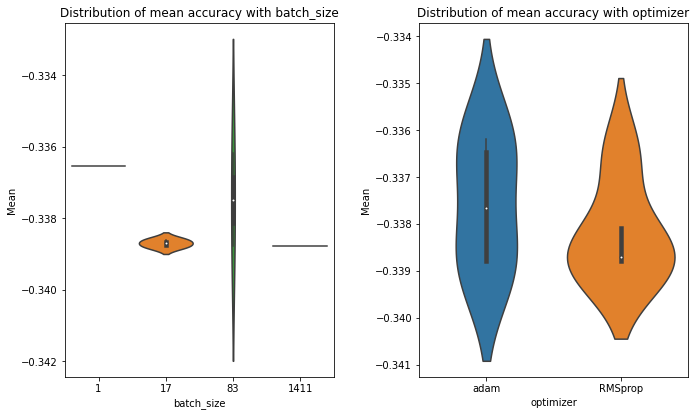

In [ ]:
param_ = ['batch_size','optimizer']
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(10,6), squeeze=False)
ax = ax.ravel()
for i in range(2):
    ax[i].set_title('Distribution of mean accuracy with {}'.format(param_[i]))
    sns.violinplot(x=param_[i],y='Mean',data=d,ax=ax[i])
fig.tight_layout(pad=1.5)

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                           input_shape=x_train_single.shape[-2:]))    # LSTM layer with 32 outputs and input shape of x_train_single.shape[-2:]
single_step_model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
single_step_model.add(tf.keras.layers.Dense(1)) # activation = sigmoid? Because I have normalised it to be between -1 and 1? Or no activation?
single_step_model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #


In [ ]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True) 
single_step_history = single_step_model.fit(train_data_single,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            callbacks=[early_stopping],
                                            validation_steps=17)    # train_length // batch_size = 

Evaluation Threshold: 20
Epochs: 500
Epoch 1/500
20/20 [==============================] - 5s 137ms/step - loss: 0.2572 - mean_absolute_error: 0.4612 - mape: 40778.1953 - val_loss: 0.1729 - val_mean_absolute_error: 0.3604 - val_mape: 347653.5000
Epoch 2/500
20/20 [==============================] - 2s 109ms/step - loss: 0.4151 - mean_absolute_error: 0.6249 - mape: 90.4268 - val_loss: 0.0807 - val_mean_absolute_error: 0.2360 - val_mape: 623030.7500
Epoch 3/500
20/20 [==============================] - 2s 114ms/step - loss: 0.2317 - mean_absolute_error: 0.4163 - mape: 817487.6250 - val_loss: 0.0328 - val_mean_absolute_error: 0.1302 - val_mape: 824493.8125
Epoch 4/500
20/20 [==============================] - 2s 108ms/step - loss: 0.0490 - mean_absolute_error: 0.1485 - mape: 40.8130 - val_loss: 0.0234 - val_mean_absolute_error: 0.0922 - val_mape: 909609.4375
Epoch 5/500
20/20 [==============================] - 2s 112ms/step - loss: 0.0914 - mean_absolute_error: 0.2241 - mape: 29.3206 - val_lo

In [ ]:
train_data_single

<RepeatDataset shapes: ((None, 320, 9), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

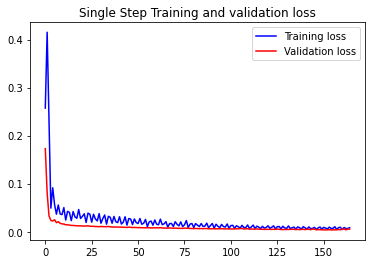

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

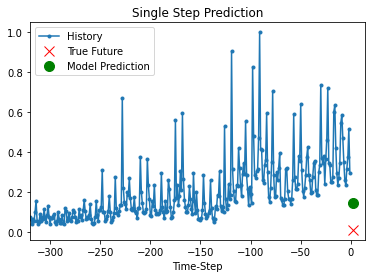

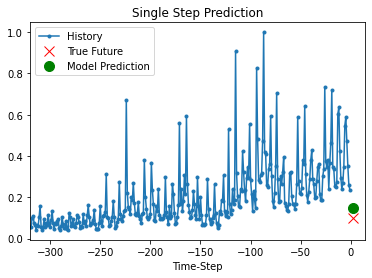

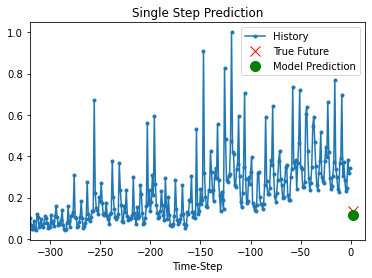

In [ ]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 2,
                   'Single Step Prediction')
    plot.show()

*How good is this prediction?*

Loss is the penalty for a bad prediction. That is, loss is a number indicating how bad the model's prediction was on a single example. If the model's prediction is perfect, the loss is zero; otherwise, the loss is greater.

With time series data it is more difficult to cross validate a model as we have to be cautious of temporal leakage. That is, the model uses past information to make predictions, therefore we cannot use k-fold validation or we would lose prediction power in the model. 

I will use Blocking Cross Validation to measure how well the model is performing. It works by adding margins at two positions. The first is between the training and validation folds in order to prevent the model from observing lag values which are used twice, once as a regressor and another as a response. The second is between the folds used at each iteration in order to prevent the model from memorizing patterns from an iteration to the next.



In [ ]:
# Blocking Cross Validation
n_splits = 10
X = dataset[:,1:]
y= dataset[:,0]

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# Keras Wrapper
from keras.wrappers.scikit_learn import KerasClassifier
def create_model():
  single_step_model = tf.keras.models.Sequential()
  single_step_model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting - is this correct?
                                           input_shape=x_train_single.shape[-2:]))    # LSTM layer with 4 outputs and input shape of x_train_single.shape[-2:]
  single_step_model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
  single_step_model.add(tf.keras.layers.Dense(1)) # 
  single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) 
  return single_step_model


In [ ]:
single_step_model = KerasClassifier(build_fn=create_model)
btscv = BlockingTimeSeriesSplit(n_splits=10)    # Or should I use TimeSeriesSplit?
mse= -cross_val_score(single_step_model, x_train_single, y_train_single, cv=btscv, scoring='neg_mean_squared_error')
mae = -cross_val_score(single_step_model, x_train_single, y_train_single, cv=btscv, scoring='neg_mean_absolute_error')
#mape = -cross_val_score(single_step_model, x_train_single, y_train_single, cv=btscv, scoring='neg_mean_absolute_percentage_error') How do I get the MAPE?

2/2 [==============================] - 2s 95ms/step - loss: 641.4139 - mean_absolute_error: 21.7650 - mape: 6490835.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 103ms/step - loss: 628.4930 - mean_absolute_error: 21.6862 - mape: 1791228.7500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 96ms/step - loss: 630.8304 - mean_absolute_error: 21.7382 - mape: 8707141.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 93ms/step - loss: 596.1930 - mean_absolute_error: 20.9018 - mape: 10296908.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 103ms/step - loss: 657.9388 - mean_absolute_error: 22.1187 - mape: 3843534.2500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 3s 92ms/step - loss: 632.3392 - mean_absolute_error: 21.5781 - mape: 2183943.7500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 94ms/step - loss: 657.0968 - mean_absolute_error: 22.1083 - mape: 3296346.7500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 96ms/step - loss: 623.8106 - mean_absolute_error: 21.5832 - mape: 4166227.2500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 95ms/step - loss: 630.7447 - mean_absolute_error: 21.5181 - mape: 12311239.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 97ms/step - loss: 671.8548 - mean_absolute_error: 22.4164 - mape: 9091911.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 98ms/step - loss: 661.0768 - mean_absolute_error: 22.2118 - mape: 5644695.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 101ms/step - loss: 628.9359 - mean_absolute_error: 21.6788 - mape: 3556197.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 3s 99ms/step - loss: 651.2943 - mean_absolute_error: 22.2018 - mape: 18659134.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 104ms/step - loss: 604.9247 - mean_absolute_error: 21.0988 - mape: 3722617.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 98ms/step - loss: 648.0346 - mean_absolute_error: 21.8773 - mape: 5144438.5000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 93ms/step - loss: 637.5922 - mean_absolute_error: 21.6681 - mape: 4912370.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 102ms/step - loss: 641.3688 - mean_absolute_error: 21.7336 - mape: 11791095.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 91ms/step - loss: 644.9628 - mean_absolute_error: 22.0628 - mape: 12636352.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 95ms/step - loss: 653.9515 - mean_absolute_error: 22.0180 - mape: 550652.3750


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 3s 96ms/step - loss: 672.0934 - mean_absolute_error: 22.4641 - mape: 14005009.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
#TimeSeries Split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
single_step_model = KerasClassifier(build_fn=create_model)
tscv = TimeSeriesSplit(n_splits=10)
mse= -cross_val_score(single_step_model, x_train_single, y_train_single, cv=tscv, scoring='neg_mean_squared_error')
mae = -cross_val_score(single_step_model, x_train_single, y_train_single, cv=tscv, scoring='neg_mean_absolute_error')
#R2 = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')

print(f"MSE: {mse.mean()} (+/- {mse.std()}")
#print(f"\nR2: {R2.mean()} (+/- {R2.std()}")

3/3 [==============================] - 2s 103ms/step - loss: 2635.6409 - mean_absolute_error: 44.4175 - mape: 4709599.5000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


6/6 [==============================] - 3s 99ms/step - loss: 9755.7881 - mean_absolute_error: 85.5578 - mape: 2131028.2500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 3s 98ms/step - loss: 21253.2129 - mean_absolute_error: 126.4039 - mape: 1679955.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


11/11 [==============================] - 3s 103ms/step - loss: 36856.2578 - mean_absolute_error: 166.4999 - mape: 156039.8281


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/14 [==============================] - 3s 97ms/step - loss: 56954.4805 - mean_absolute_error: 206.9261 - mape: 765976.1250


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


16/16 [==============================] - 4s 102ms/step - loss: 81053.6797 - mean_absolute_error: 246.7818 - mape: 130758.0156


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


19/19 [==============================] - 4s 96ms/step - loss: 110344.6172 - mean_absolute_error: 288.1127 - mape: 413889.1875


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


21/21 [==============================] - 4s 98ms/step - loss: 142685.6094 - mean_absolute_error: 327.6974 - mape: 61465.0742


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


24/24 [==============================] - 5s 97ms/step - loss: 178772.5312 - mean_absolute_error: 367.1086 - mape: 54338.8633


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


27/27 [==============================] - 5s 100ms/step - loss: 218625.4375 - mean_absolute_error: 406.2292 - mape: 259403.2969


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


3/3 [==============================] - 2s 98ms/step - loss: 2606.1108 - mean_absolute_error: 44.0784 - mape: 7976.7432


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


6/6 [==============================] - 3s 96ms/step - loss: 9710.1738 - mean_absolute_error: 85.2257 - mape: 594792.1250


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 3s 98ms/step - loss: 21058.6602 - mean_absolute_error: 125.6952 - mape: 680016.6250


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


11/11 [==============================] - 3s 97ms/step - loss: 36951.3594 - mean_absolute_error: 166.7915 - mape: 992184.8750


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/14 [==============================] - 3s 99ms/step - loss: 56857.9414 - mean_absolute_error: 206.7401 - mape: 212114.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


16/16 [==============================] - 4s 98ms/step - loss: 81183.0000 - mean_absolute_error: 247.0253 - mape: 755039.7500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


19/19 [==============================] - 4s 101ms/step - loss: 110173.8594 - mean_absolute_error: 287.8466 - mape: 611008.4375


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


21/21 [==============================] - 4s 97ms/step - loss: 142505.8281 - mean_absolute_error: 327.4793 - mape: 5818.0737


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


24/24 [==============================] - 5s 98ms/step - loss: 179369.6094 - mean_absolute_error: 367.8072 - mape: 389056.4688


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


27/27 [==============================] - 5s 99ms/step - loss: 218922.3281 - mean_absolute_error: 406.3831 - mape: 619057.5625


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


MSE: 0.4489474781329018 (+/- 0.1866174103865369


In [ ]:
print('The mean squared errors for each of the 10 splits are:', mse)
print('The mean mse for the folds is: ', (sum(mse)/10))

print('The mean absolute errors for each of the 10 splits are:', mae)
print('The mean mae for the folds is: ', (sum(mae)/10))

The mean squared errors for each of the 10 splits are: [0.14323515 0.21606474 0.24301871 0.33731154 0.50601975 0.55845455
 0.57216197 0.68120861 0.66847772 0.56352202]
The mean mse for the folds is:  0.4489474781329018
The mean absolute errors for each of the 10 splits are: [0.37552133 0.46240915 0.48902089 0.57902468 0.70567489 0.74606166
 0.75142966 0.81928164 0.81558702 0.74872487]
The mean mae for the folds is:  0.6492735768967053


In [ ]:
df_results = pd.DataFrame(mse)
df_results['RMSE'] = np.sqrt(df_results[0])
df_results = df_results.rename(columns={0:'MSFT_MSE', 'RMSE':'MSFT_RMSE'})
df_results

,MSFT_MSE,MSFT_RMSE
0,0.143235,0.378464
1,0.216065,0.464828
2,0.243019,0.492969
3,0.337312,0.580785
4,0.506020,0.711351
5,0.558455,0.747298
6,0.572162,0.756414
7,0.681209,0.825354
8,0.668478,0.817605
9,0.563522,0.750681


In [ ]:
df_results.to_csv('MSFT_SENTIMENT_LSTM_HR.csv')


In [ ]:
df_results.describe()

,MSFT_MSE,MSFT_RMSE
count,10.000000,10.000000
mean,0.448947,0.652575
std,0.196712,0.160186
min,0.143235,0.378464
25%,0.266592,0.514923
50%,0.532237,0.729324
75%,0.570002,0.754981
max,0.681209,0.825354
